<a href="https://colab.research.google.com/github/dijkstra001/ia-bot-trader/blob/main/IA_bot_trader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IA Bot Trader**

Esse projeto tem como objetivo desenvolver uma IA para realizar recomendações de compra e venda de criptomoedas.

Os dados utilizados são da Exchange Bitmex e a API utilizada está disponível no link: https://www.bitmex.com/app/apiOverview

***Obs: Ao utilizar API para requisição dos dados, cuidado para não exceder o número de requisições.***

In [1]:
!pip install -q ccxt

     |████████████████████████████████| 2.0MB 6.8MB/s 
     |████████████████████████████████| 3.2MB 40.4MB/s 
     |████████████████████████████████| 296kB 37.7MB/s 
     |████████████████████████████████| 1.3MB 41.6MB/s 
     |████████████████████████████████| 296kB 38.6MB/s 
     |████████████████████████████████| 143kB 46.3MB/s 


In [2]:
!pip install -q bayesian-optimization==1.2

In [3]:
import csv
import ccxt
import time
import random
import types
import pkg_resources
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pprint import pprint
from bayes_opt import BayesianOptimization
from google.colab import drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def generate_csv(archive, data):
  with open(archive, mode = 'w') as archive_csv:
    archive_csv.write("Date,Open,High,Low,Close,Adj Close,Volume\n")

    csv_writer = csv.writer(archive_csv, delimiter = ',', quotechar = '"', quoting = csv.QUOTE_MINIMAL)
    csv_writer.writerows(data)

In [6]:
def exchange_connection(exchange, max_retries, symbol, timeframe, since, limit):
  num_retries = 0

  try:
    num_retries += 1
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since)
    return ohlcv

  except Exception:
      if num_retries > max_retries:
        raise

In [7]:
def extract_data(exchange, max_retries, symbol, timeframe, since, limit):
  earliest_timestamp = exchange.milliseconds()

  timeframe_duration_in_sec = exchange.parse_timeframe(timeframe)
  timeframe_duration_in_ms = timeframe_duration_in_sec * 1000
  timedelta = limit * timeframe_duration_in_ms

  all_ohlcv = []

  while True:
    fetch_since = earliest_timestamp - timedelta
    ohlcv = exchange_connection(exchange, max_retries, symbol, timeframe, fetch_since, limit)

    if ohlcv[0][0] >= earliest_timestamp:
      break
    earliest_timestamp = ohlcv[0][0]
    all_ohlcv = ohlcv + all_ohlcv
    print(f'{len(all_ohlcv)} registros extraídos de {exchange.iso8601(all_ohlcv[0][0])} a {exchange.iso8601(all_ohlcv[-1][0])}')

    if fetch_since < since:
      break
  
  return all_ohlcv

In [8]:
def extract_to_csv(filename, exchange_id, max_retries, symbol, timeframe, since, limit):
    exchange = getattr(ccxt, exchange_id)({'enableRateLimit': True,})
    
    if isinstance(since, str):
        since = exchange.parse8601(since)
    exchange.load_markets()
    
    ohlcv = extract_data(exchange, max_retries, symbol, timeframe, since, limit)
    key = 0
    
    for item in ohlcv:
        epoch = int(item[0]) / 1000
        ohlcv[key][0] = datetime.utcfromtimestamp(epoch).strftime('%Y-%m-%d')
        ohlcv[key][5] = int(item[5])
        ohlcv[key].append(ohlcv[key][5])
        ohlcv[key][5] = ohlcv[key][4]
        key += 1
    ohlen = len(ohlcv)
    pprint("Número de Registros: " + str(ohlen))
    
    """if ohlen > 399:
        ohrem = ohlen - 399
        pprint("Removendo: " + str(ohrem))
        ohlcv = ohlcv[ohrem:]""" # Se não tiver recursos suficientes (ram e memória) descomente esse código
    
    generate_csv(filename, ohlcv)
    print('Salvos', len(ohlcv), 'registros no arquivo', filename)

In [9]:
# Exchange: https://www.bitmex.com/app/apiOverview
exchange = "bitmex"
symbol = "BTC/USD"
timeframe = "1d"
since = "2018-01-01T00:00:00Z"
max_retries = 3
outfile = "/content/drive/My Drive/ia-bot-trader/dataset.csv" # Aponte para o diretório onde você deseja salvar os dados

In [10]:
extract_to_csv(outfile, exchange, max_retries, symbol, timeframe, since, 100)

100 registros extraídos de 2021-02-10T00:00:00.000Z a 2021-05-20T00:00:00.000Z
200 registros extraídos de 2020-11-02T00:00:00.000Z a 2021-05-20T00:00:00.000Z
300 registros extraídos de 2020-07-25T00:00:00.000Z a 2021-05-20T00:00:00.000Z
400 registros extraídos de 2020-04-16T00:00:00.000Z a 2021-05-20T00:00:00.000Z
500 registros extraídos de 2020-01-07T00:00:00.000Z a 2021-05-20T00:00:00.000Z
600 registros extraídos de 2019-09-29T00:00:00.000Z a 2021-05-20T00:00:00.000Z
700 registros extraídos de 2019-06-21T00:00:00.000Z a 2021-05-20T00:00:00.000Z
800 registros extraídos de 2019-03-13T00:00:00.000Z a 2021-05-20T00:00:00.000Z
900 registros extraídos de 2018-12-03T00:00:00.000Z a 2021-05-20T00:00:00.000Z
1000 registros extraídos de 2018-08-25T00:00:00.000Z a 2021-05-20T00:00:00.000Z
1100 registros extraídos de 2018-05-17T00:00:00.000Z a 2021-05-20T00:00:00.000Z
1200 registros extraídos de 2018-02-06T00:00:00.000Z a 2021-05-20T00:00:00.000Z
1300 registros extraídos de 2017-10-29T00:00:00.0

# **Análise Exploratória:**

In [11]:
dataset = pd.read_csv(outfile)
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-10-29,5727.1,6366.0,5687.5,6159.3,6159.3,756109936
1,2017-10-30,6159.3,6221.8,6010.8,6134.9,6134.9,579186740
2,2017-10-31,6134.9,6489.0,6088.4,6440.1,6440.1,757390412
3,2017-11-01,6440.1,6750.0,6360.0,6749.5,6749.5,1002702139
4,2017-11-02,6749.5,7437.7,6700.3,7025.8,7025.8,1947637864


In [12]:
dataset.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1.300000e+03
mean,13085.451692,13510.485385,12606.521615,13111.762000,13111.762000,2.330912e+09
std,13232.746128,13687.688386,12688.890966,13252.093156,13252.093156,1.429822e+09
min,3183.000000,3226.000000,3121.000000,3183.000000,3183.000000,3.202566e+08
25%,6708.375000,6875.000000,6521.750000,6710.125000,6710.125000,1.333630e+09
50%,8837.000000,9079.500000,8582.750000,8842.500000,8842.500000,2.077802e+09
75%,11284.250000,11592.000000,10894.000000,11302.500000,11302.500000,2.932911e+09
max,63674.000000,65000.000000,62131.000000,63674.000000,63674.000000,1.362211e+10


In [13]:
# Dados de fechamento:
close = dataset.Close.values.tolist()

# Parâmetros para versão base do modelo:
window_size = 30
skip = 5
l = len(close) - 1

## **Estratégia de Treinamento: Deep Evolution Strategy (OpenIA):**

In [14]:
class PoliticsTrader:
  inputs = None

  def __init__(self, weights, reward_function, population_size, sigma, learning_rate):
        
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

  def get_weights_population(self, weights, population):
    
        weights_population = []
        
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        
        return weights_population

  def get_weights(self):
        return self.weights

  def train(self, epoch = 100, print_every = 1):
        
        lasttime = time.time()
        
        for i in range(epoch):
            
            population = []
            rewards = np.zeros(self.population_size)

            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            
            for k in range(self.population_size):
                weights_population = self.get_weights_population(self.weights, population[k])
                rewards[k] = self.reward_function(weights_population)
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.weights[index] = (w + self.learning_rate / (self.population_size * self.sigma) * np.dot(A.T, rewards).T)
            
            if (i + 1) % print_every == 0:
                print('Iteração %d. Recompensa: %f' % (i + 1, self.reward_function(self.weights)))
        
        print('Tempo Total de Treinamento:', time.time() - lasttime, 'segundos')


## **Arquitetura do Modelo de Rede Neural:**

In [15]:
class Model:
    
    def __init__(self, input_size, layer_size, output_size):
        
        self.weights = [np.random.randn(input_size, layer_size),
                        np.random.randn(layer_size, output_size),
                        np.random.randn(layer_size, 1),
                        np.random.randn(1, layer_size),]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        buy = np.dot(feed, self.weights[2])
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

## **Configuração do BOT:**

In [16]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    states = []
    for i in range(n - 1):
        states.append(block[i + 1] - block[i])
    return np.array([states])

In [17]:
class Trader:

    def __init__(self, population_size, sigma, learning_rate, model, money, max_buy, max_sell, skip, window_size,):
        
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = PoliticsTrader(self.model.get_weights(),
                                 self.get_reward,
                                 self.POPULATION_SIZE,
                                 self.SIGMA,
                                 self.LEARNING_RATE,)

    def execute(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    def get_reward(self, weights):
        
        initial_money = self.initial_money
        starting_money = initial_money
        
        self.model.weights = weights

        state = get_state(close, 0, self.window_size + 1)

        inventory = []
        quantity = 0
        
        for t in range(0, l, self.skip):
            
            action, buy = self.execute(state)
            
            next_state = get_state(close, t + 1, self.window_size + 1)
          
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                    
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                    
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            state = next_state
        return ((initial_money - starting_money) / starting_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def make_investiment(self):
        
        initial_money = self.initial_money
        starting_money = initial_money
        
        state = get_state(close, 0, self.window_size + 1)
              
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        
        for t in range(0, l, self.skip):
            
            action, buy = self.execute(state)
            next_state = get_state(close, t + 1, self.window_size + 1)
            
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                
                print('Dia %d: comprar %d unidades ao preço de %f, saldo total %f' % (t, buy_units, total_buy, initial_money))
            
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                    
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                
                print('Dia %d, vender %d unidades ao preço de %f, investimento %f %%, saldo total %f,' % (t, sell_units, total_sell, invest, initial_money))
            
            # Próximo estado
            state = next_state

        # Investimento
        invest = ((initial_money - starting_money) / starting_money) * 100
        
        print('\nGanho Total %f, Valor Total Investido %f' % (initial_money - starting_money, invest))
        
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'Valor Real de Fechamento', c = 'g')
        plt.plot(close, 'X', label = 'Previsão de Compra', markevery = states_buy, c = 'b')
        plt.plot(close, 'o', label = 'Previsão de Venda', markevery = states_sell, c = 'r')
        plt.legend()
        plt.show()

## **Encontrando o melhor Trader:**

In [18]:
def best_trader(window_size, skip, population_size, sigma, learning_rate, size_network):
    
    model = Model(window_size, size_network, 3)
    trader = Trader(population_size, sigma, learning_rate, model, 10000, 5, 5, skip, window_size,)
    
    try:
        trader.fit(100, 1000)
        return trader.es.reward_function(trader.es.weights)
    except:
        return 0

In [19]:
def find_best_trader(window_size, skip, population_size, sigma, learning_rate, size_network):
    
    global accbest
    
    param = {'window_size': int(np.around(window_size)),
             'skip': int(np.around(skip)),
             'population_size': int(np.around(population_size)),
             'sigma': max(min(sigma, 1), 0.0001),
             'learning_rate': max(min(learning_rate, 0.5), 0.000001),
             'size_network': int(np.around(size_network)),}
    
    print('\nBuscando Parâmetros %s' % (param))
    
    investment = best_trader(**param)
    print('Após 100 iterações o investimento foi de %f' % (investment))
    return investment

## **Otimização Bayesiana Para os Hiperparâmetros do Modelo:**

In [20]:
bayesianOpt = BayesianOptimization(find_best_trader, {'window_size': (2, 50),
                                                                  'skip': (1, 15),
                                                                  'population_size': (1, 50),
                                                                  'sigma': (0.01, 0.99),
                                                                  'learning_rate': (0.000001, 0.89),
                                                                  'size_network': (10, 1000),},)

In [21]:
%%time
bayesianOpt.maximize(init_points = 30, n_iter = 50, acq = 'ei', xi = 0.0)

|   iter    |  target   | learni... | popula... |   sigma   | size_n... |   skip    | window... |
-------------------------------------------------------------------------------------------------

Buscando Parâmetros {'window_size': 41, 'skip': 2, 'population_size': 37, 'sigma': 0.6140285787056099, 'learning_rate': 0.4820223554564559, 'size_network': 504}
Tempo Total de Treinamento: 156.76545071601868 segundos
Após 100 iterações o investimento foi de 28031.715000
|  1        |  2.803e+0 |  0.482    |  37.35    |  0.614    |  503.9    |  1.894    |  41.14    |

Buscando Parâmetros {'window_size': 14, 'skip': 5, 'population_size': 45, 'sigma': 0.6656981065363905, 'learning_rate': 0.5, 'size_network': 69}
Tempo Total de Treinamento: 27.364798069000244 segundos
Após 100 iterações o investimento foi de 14050.270000
|  2        |  1.405e+0 |  0.7696   |  45.38    |  0.6657   |  69.15    |  4.888    |  14.15    |

Buscando Parâmetros {'window_size': 32, 'skip': 11, 'population_size': 36, 'sig

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


Após 100 iterações o investimento foi de 0.000000
|  3        |  0.0      |  0.5055   |  36.32    |  0.01343  |  353.0    |  10.8     |  31.83    |

Buscando Parâmetros {'window_size': 20, 'skip': 14, 'population_size': 13, 'sigma': 0.7693498308315441, 'learning_rate': 0.5, 'size_network': 294}
Tempo Total de Treinamento: 3.8355016708374023 segundos
Após 100 iterações o investimento foi de 6412.925000
|  4        |  6.413e+0 |  0.7022   |  12.82    |  0.7693   |  294.3    |  14.18    |  20.12    |

Buscando Parâmetros {'window_size': 38, 'skip': 8, 'population_size': 22, 'sigma': 0.4540682835404962, 'learning_rate': 0.5, 'size_network': 345}
Tempo Total de Treinamento: 23.600255966186523 segundos
Após 100 iterações o investimento foi de 18217.285000
|  5        |  1.822e+0 |  0.6496   |  21.64    |  0.4541   |  345.1    |  7.79     |  37.55    |

Buscando Parâmetros {'window_size': 48, 'skip': 8, 'population_size': 9, 'sigma': 0.7198116565000491, 'learning_rate': 0.5, 'size_network': 4

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


Após 100 iterações o investimento foi de 0.000000
|  38       |  0.0      |  0.3922   |  8.913    |  0.1199   |  820.1    |  5.202    |  15.38    |

Buscando Parâmetros {'window_size': 31, 'skip': 12, 'population_size': 30, 'sigma': 0.46348691445861084, 'learning_rate': 0.08678939724978472, 'size_network': 646}
Tempo Total de Treinamento: 24.269725561141968 segundos
Após 100 iterações o investimento foi de 8528.620000
|  39       |  8.529e+0 |  0.08679  |  29.96    |  0.4635   |  646.4    |  11.66    |  30.9     |

Buscando Parâmetros {'window_size': 25, 'skip': 15, 'population_size': 10, 'sigma': 0.3348076506358129, 'learning_rate': 0.5, 'size_network': 951}
Tempo Total de Treinamento: 7.3031840324401855 segundos
Após 100 iterações o investimento foi de 3319.790000
|  40       |  3.32e+03 |  0.5486   |  9.632    |  0.3348   |  950.9    |  14.97    |  25.4     |

Buscando Parâmetros {'window_size': 28, 'skip': 10, 'population_size': 34, 'sigma': 0.026220547655275893, 'learning_rate': 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


Após 100 iterações o investimento foi de 0.000000
|  41       |  0.0      |  0.2416   |  33.84    |  0.02622  |  535.5    |  9.723    |  28.39    |

Buscando Parâmetros {'window_size': 45, 'skip': 7, 'population_size': 35, 'sigma': 0.18424108696760136, 'learning_rate': 0.2171903862935614, 'size_network': 342}
Tempo Total de Treinamento: 45.68052673339844 segundos
Após 100 iterações o investimento foi de 21469.910000
|  42       |  2.147e+0 |  0.2172   |  35.18    |  0.1842   |  342.2    |  7.276    |  44.63    |

Buscando Parâmetros {'window_size': 40, 'skip': 11, 'population_size': 45, 'sigma': 0.06831550265094773, 'learning_rate': 0.5, 'size_network': 907}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


Após 100 iterações o investimento foi de 0.000000
|  43       |  0.0      |  0.5607   |  45.49    |  0.06832  |  907.4    |  10.7     |  40.22    |

Buscando Parâmetros {'window_size': 29, 'skip': 3, 'population_size': 37, 'sigma': 0.7855170690118397, 'learning_rate': 0.3043693511199786, 'size_network': 300}
Tempo Total de Treinamento: 48.668654680252075 segundos
Após 100 iterações o investimento foi de 9279.065000
|  44       |  9.279e+0 |  0.3044   |  37.33    |  0.7855   |  299.8    |  2.891    |  29.35    |

Buscando Parâmetros {'window_size': 28, 'skip': 7, 'population_size': 20, 'sigma': 0.7058045615131907, 'learning_rate': 0.5, 'size_network': 998}
Tempo Total de Treinamento: 26.95060706138611 segundos
Após 100 iterações o investimento foi de 13461.450000
|  45       |  1.346e+0 |  0.6548   |  20.07    |  0.7058   |  997.9    |  6.852    |  27.71    |

Buscando Parâmetros {'window_size': 6, 'skip': 13, 'population_size': 36, 'sigma': 0.4652122279206555, 'learning_rate': 0.218405

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


Após 100 iterações o investimento foi de 0.000000
|  78       |  0.0      |  0.6749   |  48.39    |  0.01601  |  132.9    |  14.74    |  44.68    |

Buscando Parâmetros {'window_size': 12, 'skip': 14, 'population_size': 41, 'sigma': 0.7621348422636619, 'learning_rate': 0.4271986608738589, 'size_network': 206}
Tempo Total de Treinamento: 9.806644678115845 segundos
Após 100 iterações o investimento foi de 10757.075000
|  79       |  1.076e+0 |  0.4272   |  41.43    |  0.7621   |  205.9    |  14.29    |  12.36    |

Buscando Parâmetros {'window_size': 2, 'skip': 2, 'population_size': 26, 'sigma': 0.7648002886232216, 'learning_rate': 0.5, 'size_network': 516}
Tempo Total de Treinamento: 36.256852865219116 segundos
Após 100 iterações o investimento foi de 1805.025000
|  80       |  1.805e+0 |  0.5118   |  26.05    |  0.7648   |  515.8    |  2.066    |  2.226    |
CPU times: user 42min 36s, sys: 22min 21s, total: 1h 4min 57s
Wall time: 39min 3s


**Resultado do modelo:**

In [22]:
bayesianOpt.res

[{'params': {'learning_rate': 0.4820223554564559,
   'population_size': 37.35457814535325,
   'sigma': 0.6140285787056099,
   'size_network': 503.9074579363148,
   'skip': 1.894085804202263,
   'window_size': 41.144427832843},
  'target': 28031.715000000004},
 {'params': {'learning_rate': 0.7695782382727729,
   'population_size': 45.37704389234301,
   'sigma': 0.6656981065363905,
   'size_network': 69.14626956324403,
   'skip': 4.887733646382241,
   'window_size': 14.147631615708374},
  'target': 14050.27},
 {'params': {'learning_rate': 0.5055408301739148,
   'population_size': 36.32256723884668,
   'sigma': 0.013431316054108704,
   'size_network': 352.9977940082414,
   'skip': 10.795560879959025,
   'window_size': 31.826802098852436},
  'target': 0.0},
 {'params': {'learning_rate': 0.7022005883581353,
   'population_size': 12.817211194989483,
   'sigma': 0.7693498308315441,
   'size_network': 294.29536632552464,
   'skip': 14.176771439771548,
   'window_size': 20.124220836111938},
  '

In [23]:
max([dic['target'] for dic in bayesianOpt.res])

38871.73

In [24]:
[dic['params'] for dic in bayesianOpt.res]

[{'learning_rate': 0.4820223554564559,
  'population_size': 37.35457814535325,
  'sigma': 0.6140285787056099,
  'size_network': 503.9074579363148,
  'skip': 1.894085804202263,
  'window_size': 41.144427832843},
 {'learning_rate': 0.7695782382727729,
  'population_size': 45.37704389234301,
  'sigma': 0.6656981065363905,
  'size_network': 69.14626956324403,
  'skip': 4.887733646382241,
  'window_size': 14.147631615708374},
 {'learning_rate': 0.5055408301739148,
  'population_size': 36.32256723884668,
  'sigma': 0.013431316054108704,
  'size_network': 352.9977940082414,
  'skip': 10.795560879959025,
  'window_size': 31.826802098852436},
 {'learning_rate': 0.7022005883581353,
  'population_size': 12.817211194989483,
  'sigma': 0.7693498308315441,
  'size_network': 294.29536632552464,
  'skip': 14.176771439771548,
  'window_size': 20.124220836111938},
 {'learning_rate': 0.6496250207365153,
  'population_size': 21.639826350279865,
  'sigma': 0.4540682835404962,
  'size_network': 345.05807132

In [25]:
max([d['learning_rate'] for d in [dic['params'] for dic in bayesianOpt.res]])

0.8630921609692814

In [26]:
max([d['sigma'] for d in [dic['params'] for dic in bayesianOpt.res]])

0.9838190146549095

In [27]:
max([d['size_network'] for d in [dic['params'] for dic in bayesianOpt.res]])

997.9419279792149

## **Execução da IA:**

In [28]:
%%time
best_trader(window_size = 30, 
              skip = 1, 
              population_size = 15, 
              sigma = 0.1, 
              learning_rate = 0.03, 
              size_network = 500)

Tempo Total de Treinamento: 106.53993678092957 segundos
CPU times: user 1min 58s, sys: 1min 30s, total: 3min 29s
Wall time: 1min 46s


24737.045000000002

## **Execução do modelo base:**

In [29]:
base_model = Model(input_size = 30, layer_size = 500, output_size = 3)

trader_base = Trader(population_size = 15, 
                     sigma = 0.1, 
                     learning_rate = 0.03, 
                     model = base_model, 
                     money = 10000, 
                     max_buy = 5, 
                     max_sell = 5, 
                     skip = 1, 
                     window_size = 30)

In [30]:
%%time
trader_base.fit(500, 100)

Iteração 100. Recompensa: 15705.999000
Iteração 200. Recompensa: 25534.533000
Iteração 300. Recompensa: 34510.208000
Iteração 400. Recompensa: 36905.575000
Iteração 500. Recompensa: 39260.175000
Tempo Total de Treinamento: 530.6815838813782 segundos
CPU times: user 9min 51s, sys: 7min 31s, total: 17min 22s
Wall time: 8min 50s


## **Gerando as recomentações, com base no modelo-base:**

Dia 0: comprar 5 unidades ao preço de 30796.500000, saldo total -20796.500000
Dia 1, vender 5 unidades ao preço de 30674.500000, investimento -0.396149 %, saldo total 9878.000000,
Dia 2: comprar 5 unidades ao preço de 32200.500000, saldo total -22322.500000
Dia 5, vender 5 unidades ao preço de 35732.500000, investimento 10.968774 %, saldo total 13410.000000,
Dia 6: comprar 5 unidades ao preço de 36969.500000, saldo total -23559.500000
Dia 7, vender 5 unidades ao preço de 36891.500000, investimento -0.210985 %, saldo total 13332.000000,
Dia 13: comprar 5 unidades ao preço de 31727.500000, saldo total -18395.500000
Dia 20, vender 5 unidades ao preço de 39027.500000, investimento 23.008431 %, saldo total 20632.000000,
Dia 24: comprar 5 unidades ao preço de 41095.000000, saldo total -20463.000000
Dia 34, vender 5 unidades ao preço de 54552.500000, investimento 32.747293 %, saldo total 34089.500000,
Dia 36: comprar 5 unidades ao preço de 58410.000000, saldo total -24320.500000
Dia 40, vende

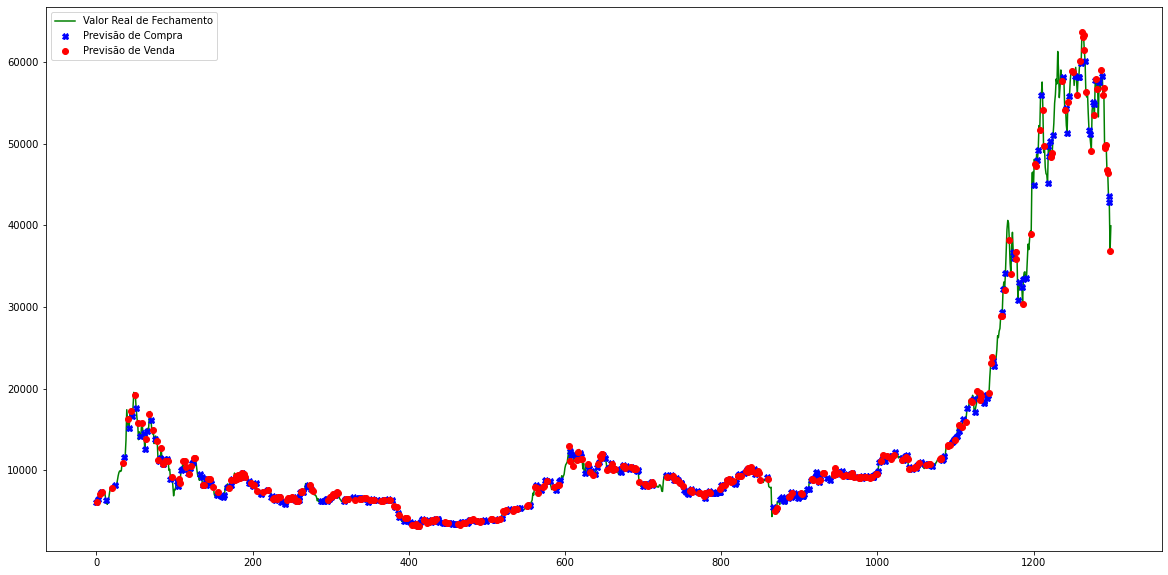

In [31]:
trader_base.make_investiment()

## **Execução da IA com modelo otimizado:**

In [32]:
%%time
best_trader(window_size = int(np.around(max([d['window_size'] for d in [dic['params'] for dic in bayesianOpt.res]]))), 
              skip = int(np.around(max([d['skip'] for d in [dic['params'] for dic in bayesianOpt.res]]))), 
              population_size = int(max([d['population_size'] for d in [dic['params'] for dic in bayesianOpt.res]])), 
              sigma = max([d['sigma'] for d in [dic['params'] for dic in bayesianOpt.res]]), 
              learning_rate = max([d['learning_rate'] for d in [dic['params'] for dic in bayesianOpt.res]]), 
              size_network = int(np.around(max([d['size_network'] for d in [dic['params'] for dic in bayesianOpt.res]]))))

Tempo Total de Treinamento: 52.79903268814087 segundos
CPU times: user 59.7 s, sys: 39.6 s, total: 1min 39s
Wall time: 52.8 s


11286.1

In [33]:
%%time
opt_model = Model(input_size = int(np.around(max([d['window_size'] for d in [dic['params'] for dic in bayesianOpt.res]]))), 
                     layer_size = int(np.around(max([d['size_network'] for d in [dic['params'] for dic in bayesianOpt.res]]))), 
                     output_size = 3)

CPU times: user 4.15 ms, sys: 3.86 ms, total: 8.01 ms
Wall time: 4.02 ms


## **Criação do modelo otimizado:**

In [34]:
trader_opt = Trader(population_size = int(np.around(max([d['population_size'] for d in [dic['params'] for dic in bayesianOpt.res]]))), 
                     sigma = max([d['sigma'] for d in [dic['params'] for dic in bayesianOpt.res]]), 
                     learning_rate = max([d['learning_rate'] for d in [dic['params'] for dic in bayesianOpt.res]]), 
                     model = opt_model, 
                     money = 10000, 
                     max_buy = 5, 
                     max_sell = 5, 
                     skip = int(np.around(max([d['skip'] for d in [dic['params'] for dic in bayesianOpt.res]]))), 
                     window_size = int(np.around(max([d['window_size'] for d in [dic['params'] for dic in bayesianOpt.res]]))))

## **Treinamento do modelo otimizado:**



In [35]:
%%time
trader_opt.fit(500, 100)

Iteração 100. Recompensa: 12765.810000
Iteração 200. Recompensa: 15282.560000
Iteração 300. Recompensa: 16794.760000
Iteração 400. Recompensa: 16759.030000
Iteração 500. Recompensa: 16760.555000
Tempo Total de Treinamento: 266.80666422843933 segundos
CPU times: user 5min 1s, sys: 3min 20s, total: 8min 22s
Wall time: 4min 26s


## **Realizando as recomendações, com base no modelo otimizado:**

Dia 0: comprar 5 unidades ao preço de 30796.500000, saldo total -20796.500000
Dia 45, vender 5 unidades ao preço de 82182.500000, investimento 166.856623 %, saldo total 61386.000000,
Dia 105: comprar 5 unidades ao preço de 40325.000000, saldo total 21061.000000
Dia 120, vender 5 unidades ao preço de 51582.500000, investimento 27.916925 %, saldo total 72643.500000,
Dia 240: comprar 5 unidades ao preço de 30370.000000, saldo total 42273.500000
Dia 270, vender 5 unidades ao preço de 39610.000000, investimento 30.424761 %, saldo total 81883.500000,
Dia 435: comprar 5 unidades ao preço de 20025.000000, saldo total 61858.500000
Dia 465: comprar 5 unidades ao preço de 16827.500000, saldo total 45031.000000
Dia 480: comprar 5 unidades ao preço de 19487.500000, saldo total 25543.500000
Dia 495: comprar 5 unidades ao preço de 19200.000000, saldo total 6343.500000
Dia 510: comprar 5 unidades ao preço de 19897.500000, saldo total -13554.000000
Dia 615, vender 5 unidades ao preço de 56170.000000, i

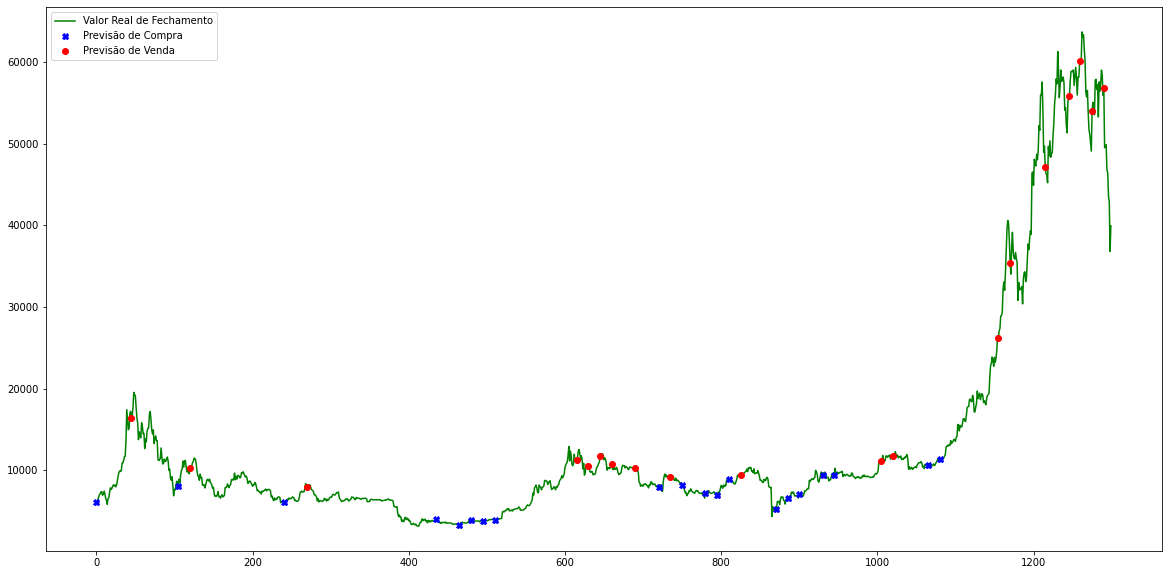

CPU times: user 348 ms, sys: 137 ms, total: 485 ms
Wall time: 344 ms


In [36]:
%%time
trader_opt.make_investiment()